# Data Preprocessing Project 
### Team: Survivors

In [1]:
# Warming Up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fPath = './data/vgsales.csv'
df = pd.read_csv(fPath)

# trying to create 1.5% worth of duplicates
rws = df.shape[0]
col = df.shape[1]

print('Number of instances = %d' % (rws))
print('Number of attributes = %d' % (col))
print(df.head())
# Tables that Michael Berbach will use
dfMB = df

Number of instances = 16598
Number of attributes = 11
   Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.82  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.37  


# Missing Values

Author: Micheal Berbach | The purpose of this is to find any missing values 

In [2]:
data = df.replace('?',np.NaN)

print('Number of instances = %d' % (rws))
print('Number of attributes = %d' % (col))

print('Number of missing values:')
for col in df.columns:
    print('\t%s: %d' % (col,df[col].isna().sum()))

Number of instances = 16598
Number of attributes = 11
Number of missing values:
	Rank: 0
	Name: 0
	Platform: 0
	Year: 271
	Genre: 0
	Publisher: 58
	NA_Sales: 0
	EU_Sales: 0
	JP_Sales: 0
	Other_Sales: 0
	Global_Sales: 0


In [3]:
print('Number of rows in original data = %d' % (rws))
df = df.dropna()
print('Number of rows after discarding missing values = %d' % (df.shape[0]))
print('Difference in number of rows = %d' % (rws-df.shape[0]))
# update rws
rws = df.shape[0]

Number of rows in original data = 16598
Number of rows after discarding missing values = 16291
Difference in number of rows = 307


# Duplicate Data

Author: Micheal Berbach | The purpose of this is to find any duplicate datas 

In [4]:

# It was found that duplicates exist when the rank attribute is removed
dfMB = dfMB.drop(['Rank'], axis=1)
dups = dfMB.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
dfMB.loc[dfMB.duplicated(keep=False)]

Number of duplicate rows = 1


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
14997,Wii de Asobu: Metroid Prime,Wii,NaN,Shooter,Nintendo,0.0,0.0,0.02,0.0,0.02
14999,Wii de Asobu: Metroid Prime,Wii,NaN,Shooter,Nintendo,0.0,0.0,0.02,0.0,0.02


In [5]:
print('Number of rows before discarding duplicates = %d' % (rws))
dfMB = dfMB.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (dfMB.shape[0]))

Number of rows before discarding duplicates = 16291
Number of rows after discarding duplicates = 16597


# Splitting Training, Validation, and Testing data
Author: Rahul Gupta | To get our data set ready for a neural network, we need to split the data set into training, validation, and testing data. We will also need to use randomization to try and avoid any disproportionate records or bias. Choosing to split prior to other steps such as normalization because the testing data will be coming in as-is.

### Shuffling
Using shuffling to randomize the dataset before splitting to avoid having any disproportionate records or bias.

In [6]:
df_shuffled = df.sample(frac=1, random_state=42)

### Splitting
We'll use splitting to divide the data set into training, validation, and testing. This will be crucial for training the neural network and ensuring it's working as expected before using it on test data. For this scenario, we will use a 70%, 15%, and 15% split for training, validation, and testing accordingly.

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_valid_df = train_test_split(df_shuffled, test_size=0.3, random_state=42)
test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)

train_df[20:23]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
15974,15977,Misshitsu no Sacrifice,PSP,2010.0,Adventure,D3Publisher,0.00,0.00,0.02,0.00,0.02
9177,9179,Eragon,X360,2006.0,Action,Vivendi Games,0.12,0.01,0.00,0.01,0.14
13655,13657,Phantom Kingdom Portable,PSP,2011.0,Role-Playing,Nippon Ichi Software,0.00,0.00,0.04,0.00,0.04


### Dropping
Depending on what we want to predict with the neural network, we can drop the appropriate column for the test and validation dataframes. For example, if we want the neural network to predict Global_Sales, we would drop that column for validation and training dataframes.

In [8]:
valid_global_sales = valid_df['Global_Sales']
valid_df = valid_df.drop(['Global_Sales'], axis=1)
test_df = test_df.drop(['Global_Sales'], axis=1)

test_df[20:23]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
9941,9943,CSI: Crime Scene Investigation,XB,2004.0,Adventure,Ubisoft,0.09,0.03,0.00,0.00
4188,4190,Quest 64,N64,1998.0,Role-Playing,Konami Digital Entertainment,0.38,0.08,0.00,0.01
15323,15326,Meikyuu Cross Blood: Reloaded,X360,2011.0,Action,Unknown,0.00,0.00,0.02,0.00


# Outliers
Author: Rahul Gupta | One way of preprocessing the data set is to prepare it for predicting a video game's sales based on its genre. It could be useful for publishers to know what genre of game to develop based on a prediction with this data. To do so, we will need to prepare the data set for normalization and remove outliers.

### One Hot Encoding
Start by using one-hot encoding to convert the genre categorical attribute into numerical values. One-hot encoding is crucial if we are including genre and normalizing the data set since categorical attributes without one-hot encoding are not compatible with normalization.

In [9]:
normalized = train_df
one_hot = pd.get_dummies(normalized['Genre'])

one_hot[20:23]

,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
15974,False,True,False,False,False,False,False,False,False,False,False,False
9177,True,False,False,False,False,False,False,False,False,False,False,False
13655,False,False,False,False,False,False,False,True,False,False,False,False


### Dropping Columns
We also need to drop columns that do not fit the specific needs of the neural network. In this case, anything that is not genre or sales data. However, we will also drop genre as well and later replace it with the one-hot encoded columns made in the previous step.

In [10]:
print('Number of columns before discarding columns = %d' % (normalized.shape[1]))

normalized = normalized.drop(['Rank', 'Name', 'Platform', 'Genre', 'Year', 'Publisher'], axis=1)

print('Number of columns after discarding columns = %d' % (normalized.shape[1]))

Number of columns before discarding columns = 11
Number of columns after discarding columns = 5


### Concatenating Rows and Columns
After dropping the unnecessary columns, we now want to add the one-hot encoded genres to the main dataframe. To add the one-hot encoded rows and columns to the dataframe, we will use the pandas function concat, which will combine them both into one dataframe.

In [11]:
normalized = pd.concat([one_hot, normalized], axis=1)

normalized[20:23]

,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
15974,False,True,False,False,False,False,False,False,False,False,False,False,0.00,0.00,0.02,0.00,0.02
9177,True,False,False,False,False,False,False,False,False,False,False,False,0.12,0.01,0.00,0.01,0.14
13655,False,False,False,False,False,False,False,True,False,False,False,False,0.00,0.00,0.04,0.00,0.04


### Normalization
Now, we will normalize the data to find and remove any outliers. Doing so will make it easier for the neural network to find and identify patterns with genre and sales data. All data will be converted into z scores with the following formula: z score = (x - mean)/standard deviation.

In [12]:
normalized = (normalized-normalized.mean())/normalized.std()

normalized[20:23]

,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
15974,-0.501266,3.436761,-0.231063,-0.335054,-0.237519,-0.186419,-0.286132,-0.315771,-0.292009,-0.237313,-0.408523,-0.207329,-0.315485,-0.283721,-0.188928,-0.288381,-0.325574
9177,1.994775,-0.290946,-0.231063,-0.335054,-0.237519,-0.186419,-0.286132,-0.315771,-0.292009,-0.237313,-0.408523,-0.207329,-0.173491,-0.264400,-0.251512,-0.225305,-0.250414
13655,-0.501266,-0.290946,-0.231063,-0.335054,-0.237519,-0.186419,-0.286132,3.166570,-0.292009,-0.237313,-0.408523,-0.207329,-0.315485,-0.283721,-0.126344,-0.288381,-0.313047


### Removing Outliers
After getting z scores, it is now possible to find outliers and remove them. Since all columns have been converted into z scores, we need to see if values are greater than -3 or less than or equal to 3. Rows that fall into that range are not outliers and are included in removed_outliers. However, rows that fall outside of that range are outliers and are excluded from the dataframe removed_outliers.


In [13]:
print('Number of rows before discarding outliers = %d' % (normalized.shape[0]))

removed_outliers = normalized.loc[((normalized > -3).sum(axis=1)==17) & ((normalized <= 3).sum(axis=1)==17)]
print('Number of rows after discarding outliers values = %d' % (removed_outliers.shape[0]))

removed_outliers[20:23]

Number of rows before discarding outliers = 11403
Number of rows after discarding outliers values = 4946


,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
838,-0.501266,-0.290946,-0.231063,2.984335,-0.237519,-0.186419,-0.286132,-0.315771,-0.292009,-0.237313,-0.408523,-0.207329,1.423934,0.489102,-0.251512,0.720835,0.933343
7000,-0.501266,-0.290946,-0.231063,2.984335,-0.237519,-0.186419,-0.286132,-0.315771,-0.292009,-0.237313,-0.408523,-0.207329,-0.055164,-0.283721,-0.251512,-0.162229,-0.194045
3320,1.994775,-0.290946,-0.231063,-0.335054,-0.237519,-0.186419,-0.286132,-0.315771,-0.292009,-0.237313,-0.408523,-0.207329,0.205158,0.025408,-0.251512,-0.225305,0.043959


#### Insights
A large amount of enteries have been classified as outliers. There may be anomolies in the data set that require further investigation beyond preprocessing or it is also possible that normalizing using z score is not the most appropriate option of this particular dataset.

# Shuffling Dataframes

Author: Micheal Berbach

In [14]:
dfMB = dfMB.reindex(np.random.permutation(dfMB.index))
dfMB.reset_index(inplace=True, drop=True)
dfMB
# Shuffling is aparent as it was
# originally ranked in order of global sales

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Madden NFL 2002,GBA,2001.0,Sports,Electronic Arts,0.23,0.08,0.00,0.01,0.32
1,Brain Boost: Gamma Wave,DS,2005.0,Puzzle,505 Games,0.14,0.00,0.00,0.01,0.15
2,Pro Evolution Soccer 2012,PS2,2011.0,Action,Konami Digital Entertainment,0.00,0.00,0.06,0.00,0.06
3,Elements of Destruction,DS,2007.0,Strategy,THQ,0.07,0.00,0.00,0.01,0.07
4,Kenkou Ouen Recipe 1000: DS Kondate Zenshuu,DS,2006.0,Misc,Nintendo,0.00,0.00,0.52,0.00,0.52
...,...,...,...,...,...,...,...,...,...,...
16592,Army Men: Green Rogue,PS,2001.0,Action,3DO,0.04,0.02,0.00,0.00,0.07
16593,Battle Hunter,PS,1999.0,Strategy,Midas Interactive Entertainment,0.02,0.01,0.00,0.00,0.04
16594,Disney Sing It: Pop Hits,Wii,2009.0,Misc,Disney Interactive Studios,1.08,0.28,0.00,0.13,1.49
16595,Hot Shots Tennis: Get a Grip,PSP,2010.0,Sports,Sony Computer Entertainment,0.06,0.00,0.13,0.01,0.21


# Sorting Dataframes

Author: Micheal Berbach

In [15]:
# sorting first by year, then by global sales
dfMB = dfMB.sort_values(by=['Year','Global_Sales'],ascending=[True, False])
# Also getting rid of any rows that dont have a year
# So we can see the full range
dfMB = dfMB.dropna(subset=['Year'])
dfMB

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
11417,Asteroids,2600,1980.0,Shooter,Atari,4.00,0.26,0.00,0.05,4.31
6364,Missile Command,2600,1980.0,Shooter,Atari,2.56,0.17,0.00,0.03,2.76
213,Kaboom!,2600,1980.0,Misc,Activision,1.07,0.07,0.00,0.01,1.15
13530,Defender,2600,1980.0,Misc,Atari,0.99,0.05,0.00,0.01,1.05
5516,Boxing,2600,1980.0,Fighting,Activision,0.72,0.04,0.00,0.01,0.77
...,...,...,...,...,...,...,...,...,...,...
15984,Period Cube: Torikago no Amadeus,PSV,2016.0,Action,Idea Factory,0.00,0.00,0.01,0.00,0.01
2340,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,0.00,0.00,0.03,0.00,0.03
5291,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,0.00,0.00,0.01,0.00,0.01
13760,Phantasy Star Online 2 Episode 4: Deluxe Package,PSV,2017.0,Role-Playing,Sega,0.00,0.00,0.01,0.00,0.01


We can see it spans about 40 years with the data we have left

In [16]:
print("The first game with the most sales is: {}".format(dfMB['Name'].iloc[0]))
print("The first car is: {}".format(dfMB['Name'].loc[0]))
# check readout from shuffling frames if confused by what above line produces

#loc gets rows (or columns) with particular labels from the index.
#iloc gets rows (or columns) at particular positions in the index (so it only takes integers).

The first game with the most sales is: Asteroids
The first car is: Madden NFL 2002


# Saving a Dataframe

Author: Micheal Berbach

In [17]:
import os

# Relative path within the repository
writeFlnam = os.path.join("data", "vgsalesMB.csv")

# Ensure the 'data' directory exists
os.makedirs(os.path.dirname(writeFlnam), exist_ok=True)

# Save the DataFrame
dfMB.to_csv(writeFlnam, index=False)
print("DataFrame saved to: {}".format(writeFlnam))

DataFrame saved to: data\vgsalesMB.csv


# Shuffle the dataframe

Author: Warisara Lee | The purpose of this is to shuffle the dataframe

In [18]:
df = df.reindex(np.random.permutation(df.index))
df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
14305,14308,Saru! Get You! SaruSaru Daisakusen,PSP,2007.0,Platform,Sony Computer Entertainment,0.00,0.00,0.03,0.00,0.03
15781,15784,Gears of War,PC,2007.0,Shooter,Microsoft Game Studios,0.00,0.01,0.00,0.00,0.02
6469,6471,Tales of Innocence,DS,2007.0,Role-Playing,Namco Bandai Games,0.00,0.00,0.26,0.00,0.26
1846,1848,Toy Story 3: The Video Game,PS3,2010.0,Action,Disney Interactive Studios,0.51,0.42,0.00,0.17,1.11
4575,4577,LEGO Rock Band,PS3,2009.0,Misc,Warner Bros. Interactive Entertainment,0.24,0.13,0.00,0.06,0.42
...,...,...,...,...,...,...,...,...,...,...,...
3342,3344,The Golden Compass,DS,2007.0,Action,Sega,0.28,0.25,0.00,0.06,0.60
15574,15577,7 Roses: A Darkness Rises,PC,2015.0,Misc,Avanquest Software,0.00,0.02,0.00,0.00,0.02
3524,3526,Madden NFL 06,GC,2005.0,Sports,Electronic Arts,0.44,0.11,0.00,0.02,0.57
9348,9350,Hisshou Pachinko*Pachi-Slot Kouryaku Series Vo...,PS2,2005.0,Misc,D3Publisher,0.00,0.00,0.13,0.00,0.13


In [19]:
df.reset_index(inplace=True, drop=True)
df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,14308,Saru! Get You! SaruSaru Daisakusen,PSP,2007.0,Platform,Sony Computer Entertainment,0.00,0.00,0.03,0.00,0.03
1,15784,Gears of War,PC,2007.0,Shooter,Microsoft Game Studios,0.00,0.01,0.00,0.00,0.02
2,6471,Tales of Innocence,DS,2007.0,Role-Playing,Namco Bandai Games,0.00,0.00,0.26,0.00,0.26
3,1848,Toy Story 3: The Video Game,PS3,2010.0,Action,Disney Interactive Studios,0.51,0.42,0.00,0.17,1.11
4,4577,LEGO Rock Band,PS3,2009.0,Misc,Warner Bros. Interactive Entertainment,0.24,0.13,0.00,0.06,0.42
...,...,...,...,...,...,...,...,...,...,...,...
16286,3344,The Golden Compass,DS,2007.0,Action,Sega,0.28,0.25,0.00,0.06,0.60
16287,15577,7 Roses: A Darkness Rises,PC,2015.0,Misc,Avanquest Software,0.00,0.02,0.00,0.00,0.02
16288,3526,Madden NFL 06,GC,2005.0,Sports,Electronic Arts,0.44,0.11,0.00,0.02,0.57
16289,9350,Hisshou Pachinko*Pachi-Slot Kouryaku Series Vo...,PS2,2005.0,Misc,D3Publisher,0.00,0.00,0.13,0.00,0.13


# Sort the Dataframe

Author: Warisara Lee

In [20]:
print("Before sorting")
print(df['Global_Sales'])
df = df.sort_values(by='Global_Sales',ascending=True)

print("\nAfter sorting")
print(df['Global_Sales']) 

Before sorting
0        0.03
1        0.02
2        0.26
3        1.11
4        0.42
         ... 
16286    0.60
16287    0.02
16288    0.57
16289    0.13
16290    1.75
Name: Global_Sales, Length: 16291, dtype: float64

After sorting
2348      0.01
6409      0.01
6430      0.01
1653      0.01
641       0.01
         ...  
1398     31.37
15546    33.00
1283     35.82
12821    40.24
3225     82.74
Name: Global_Sales, Length: 16291, dtype: float64


In [21]:
print("df['Global_Sales'].iloc[0] is: {}".format(df['Global_Sales'].iloc[0]))

print("df['Global_Sales'].loc[0] is: {}".format(df['Global_Sales'].loc[0])) 

df['Global_Sales'].iloc[0] is: 0.01
df['Global_Sales'].loc[0] is: 0.03


In [22]:
#Sorting in Ascending Order
#Sorting by column 'NA_Sales'
df = df.sort_values(by=['NA_Sales'],ascending=True)
df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
2348,16537,Time Travelers,PSP,2012.0,Adventure,Level 5,0.00,0.00,0.01,0.00,0.01
6807,7383,Naruto: Clash of Ninja (JP sales),GC,2003.0,Fighting,Tomy Corporation,0.00,0.00,0.21,0.01,0.21
13327,7323,SingStar: Back to the 80s,PS3,2011.0,Misc,Sony Computer Entertainment,0.00,0.16,0.00,0.05,0.21
4034,7335,We Sing Robbie Williams,Wii,2010.0,Misc,Nordic Games,0.00,0.19,0.00,0.03,0.21
10774,12859,Saki: Zenkoku-hen,PSV,2015.0,Misc,Kaga Create,0.00,0.00,0.05,0.00,0.05
...,...,...,...,...,...,...,...,...,...,...,...
1283,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3120,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
8739,10,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31
12821,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24


In [23]:
#Sorting in Descending Order
#Sorting by column "EU_Sales"
df = df.sort_values(by=['EU_Sales'], ascending=False)
df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
3225,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1283,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
15546,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
5970,11,Nintendogs,DS,2005.0,Simulation,Nintendo,9.07,11.00,1.93,2.75,24.76
3789,17,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.40
...,...,...,...,...,...,...,...,...,...,...,...
11177,15725,Zoids Dash,DS,2006.0,Role-Playing,Tomy Corporation,0.00,0.00,0.02,0.00,0.02
15488,3022,Zaidan Houjin Nippon Kanji Nouryoko Kentei Kyo...,DS,2006.0,Misc,Rocket Company,0.00,0.00,0.67,0.00,0.67
11312,15413,Guitar Freaks V2 & DrumMania V2,PS2,2006.0,Simulation,Konami Digital Entertainment,0.00,0.00,0.02,0.00,0.02
14114,3027,Taiko no Tatsujin Wii,Wii,2008.0,Misc,Namco Bandai Games,0.00,0.00,0.67,0.00,0.67


# Sampling

Author: Maddie Ananda Subramanian | Sampling the data that we have found

In [24]:
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [25]:
sample = data.sample(n=10)
sample

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
7699,7701,Ore no Shikabane o Koete Yuke,PSP,2011.0,Role-Playing,Sony Computer Entertainment,0.00,0.00,0.2,0.00,0.20
8653,8655,Left Brain Right Brain: Use Both Hands Train B...,DS,2007.0,Misc,505 Games,0.15,0.00,0.0,0.01,0.16
3356,3358,Jaws Unleashed,PS2,2006.0,Action,THQ,0.50,0.02,0.0,0.08,0.60
11199,11201,LEGO Star Wars II: The Original Trilogy,GBA,2006.0,Action,LucasArts,0.06,0.02,0.0,0.00,0.09
15644,15647,NHL 2K3,GC,2002.0,Sports,Sega,0.01,0.00,0.0,0.00,0.02
8698,8700,Darksiders II,PC,2012.0,Action,Nordic Games,0.03,0.10,0.0,0.03,0.16
13137,13139,Turbo Turtle Adventure,GBA,2002.0,Puzzle,Majesco Entertainment,0.04,0.01,0.0,0.00,0.05
13915,13917,Rabbids Land,WiiU,2012.0,Misc,Ubisoft,0.02,0.01,0.0,0.00,0.04
7895,7897,Boogie,PS2,2007.0,Misc,Electronic Arts,0.09,0.07,0.0,0.02,0.19
5545,5547,MVP Baseball 2005,GC,2005.0,Sports,Electronic Arts,0.25,0.07,0.0,0.01,0.33


In [26]:
sample = data.sample(frac=0.01, random_state=999)
sample

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
10725,10727,The Land Before Time: Great Valley Racing Adve...,PS,2001.0,Racing,TDK Mediactive,0.05,0.04,0.00,0.01,0.10
9053,9055,Mojo!,PS2,2003.0,Puzzle,Mindscape,0.07,0.05,0.00,0.02,0.14
10102,10104,Vacation Sports,Wii,2009.0,Sports,Ubisoft,0.10,0.01,0.00,0.01,0.11
11876,11878,Disney's Donald Duck Advance,GBA,2001.0,Platform,Ubisoft,0.05,0.02,0.00,0.00,0.07
14561,14564,Gekiatsu!! Pachi Game Tamashi Vol. 1: CR Evang...,PSP,2011.0,Misc,Unknown,0.00,0.00,0.03,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...
6592,6594,Silent Hunter 5: Battle of the Atlantic,PC,2010.0,Simulation,Ubisoft,0.00,0.21,0.00,0.05,0.26
4539,4541,EverQuest Online Adventures,PS2,2003.0,Role-Playing,Sony Online Entertainment,0.21,0.16,0.00,0.05,0.43
9920,9922,SD Gundam G Generation-F.I.F,PS,2001.0,Strategy,Namco Bandai Games,0.00,0.00,0.11,0.01,0.12
14440,14443,Eyeshield 21: DevilBats DevilDays,GBA,2006.0,Role-Playing,Nintendo,0.00,0.00,0.03,0.00,0.03


In [27]:
sample = data.sample(frac=0.01, replace=True, random_state=999)
sample

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
12636,12638,Adventures of Lolo,NES,1989.0,Puzzle,HAL Laboratory,0.06,0.00,0.00,0.00,0.06
13157,13159,Nike+ Kinect Training,X360,2012.0,Sports,Microsoft Game Studios,0.02,0.02,0.00,0.00,0.05
5832,5834,Karaoke Revolution Glee: Volume 3,Wii,2011.0,Misc,Konami Digital Entertainment,0.24,0.04,0.00,0.02,0.30
8417,8419,WRC 2: FIA World Rally Championship,PS3,2011.0,Racing,Ubisoft,0.00,0.13,0.00,0.04,0.17
10715,10717,Lord of Apocalypse,PSP,2011.0,Role-Playing,Square Enix,0.00,0.00,0.10,0.00,0.10
...,...,...,...,...,...,...,...,...,...,...,...
5585,5587,Resident Evil: Revelations 2,PS3,2015.0,Action,Capcom,0.06,0.08,0.16,0.03,0.32
10519,10521,God Eater 2: Rage Burst,PS4,2015.0,Role-Playing,Namco Bandai Games,0.00,0.01,0.09,0.00,0.10
6322,6324,Fushigi no Dungeon: Fuurai no Shiren GB: Tsuki...,GB,1996.0,Role-Playing,ChunSoft,0.00,0.00,0.27,0.00,0.27
1982,1984,Forza Motorsport,XB,2005.0,Racing,Microsoft Game Studios,0.52,0.51,0.00,0.02,1.05


# Data before and after dropping any columns

Author: Maddie Ananda Subramanian | The purpose of this is to show how the data is before and dropping certain columns

In [28]:
print("Data before dropping any columns:")
print(df.head())

Data before dropping any columns:
       Rank                Name Platform    Year       Genre  \
3225      1          Wii Sports      Wii  2006.0      Sports   
1283      3      Mario Kart Wii      Wii  2008.0      Racing   
15546     4   Wii Sports Resort      Wii  2009.0      Sports   
5970     11          Nintendogs       DS  2005.0  Simulation   
3789     17  Grand Theft Auto V      PS3  2013.0      Action   

                  Publisher  NA_Sales  EU_Sales  JP_Sales  Other_Sales  \
3225               Nintendo     41.49     29.02      3.77         8.46   
1283               Nintendo     15.85     12.88      3.79         3.31   
15546              Nintendo     15.75     11.01      3.28         2.96   
5970               Nintendo      9.07     11.00      1.93         2.75   
3789   Take-Two Interactive      7.01      9.27      0.97         4.14   

       Global_Sales  
3225          82.74  
1283          35.82  
15546         33.00  
5970          24.76  
3789          21.40  


In [29]:
if 'Rank' in df.columns:
    df.drop('Rank', axis=1, inplace=True)
else:
    print("'Rank' column not found in the DataFrame")

print("\nData after dropping the columns:")
print(df.head())


Data after dropping the columns:
                     Name Platform    Year       Genre             Publisher  \
3225           Wii Sports      Wii  2006.0      Sports              Nintendo   
1283       Mario Kart Wii      Wii  2008.0      Racing              Nintendo   
15546   Wii Sports Resort      Wii  2009.0      Sports              Nintendo   
5970           Nintendogs       DS  2005.0  Simulation              Nintendo   
3789   Grand Theft Auto V      PS3  2013.0      Action  Take-Two Interactive   

       NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
3225      41.49     29.02      3.77         8.46         82.74  
1283      15.85     12.88      3.79         3.31         35.82  
15546     15.75     11.01      3.28         2.96         33.00  
5970       9.07     11.00      1.93         2.75         24.76  
3789       7.01      9.27      0.97         4.14         21.40  


# Discretization

Author: Robby Dosanjh | The purpose of this is to discrete quantity and/or quantities and transform a continuousvalued attribute to a categorical attribute

### Step 1: Plotting the Histogram and Value Counts for Global Sales

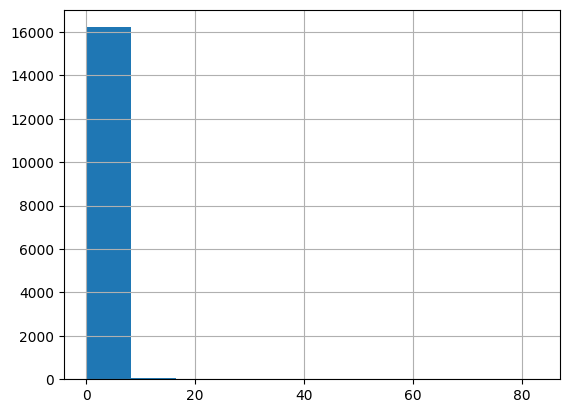

Global_Sales
82.74    1
35.82    1
33.00    1
24.76    1
21.40    1
        ..
11.66    1
4.23     1
5.95     1
3.14     1
4.87     1
Name: count, Length: 621, dtype: int64


In [30]:
# Plot a histogram for the Global Sales
df['Global_Sales'].hist(bins=10)
plt.show()

# Count the frequency of each Global Sales value
print(df['Global_Sales'].value_counts(sort=False))

In [31]:
"""
Step 2: 
Equal Width Discretization into 4 bins
This method divides the range of Global Sales into 4 bins of equal interval widths, categorizing the continuous sales data into discrete intervals.
"""

# Equal Width Discretization into 4 bins
bins_equal_width = pd.cut(df['Global_Sales'], 4)
print(bins_equal_width.value_counts(sort=False))

Global_Sales
(-0.0727, 20.692]    16273
(20.692, 41.375]        17
(41.375, 62.057]         0
(62.057, 82.74]          1
Name: count, dtype: int64


In [32]:
"""
Step 3:
Equal Frequency Discretization into 4 bins
This method divides the Global Sales data into 4 bins such that each bin contains approximately the same number of records, ensuring an even distribution across bins
"""
# Equal Frequency Discretization into 4 bins
bins_equal_freq = pd.qcut(df['Global_Sales'], 4)
print(bins_equal_freq.value_counts(sort=False))

Global_Sales
(0.009000000000000001, 0.06]    4266
(0.06, 0.17]                    3963
(0.17, 0.48]                    4039
(0.48, 82.74]                   4023
Name: count, dtype: int64


# Aggregation

Author: Isaiah Samaniego | The purpose is to aggregate NA, EU, JP, and Other sales into the single object Global_Sales

In [33]:
x = df.drop('Global_Sales', axis=1)
#Aggregates NA,EU, JP, and Other sales into the single object Global_Sales
x['Global_Sales'] = x[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum(axis=1)
print(x)

                                                    Name Platform    Year  \
3225                                          Wii Sports      Wii  2006.0   
1283                                      Mario Kart Wii      Wii  2008.0   
15546                                  Wii Sports Resort      Wii  2009.0   
5970                                          Nintendogs       DS  2005.0   
3789                                  Grand Theft Auto V      PS3  2013.0   
...                                                  ...      ...     ...   
11177                                         Zoids Dash       DS  2006.0   
15488  Zaidan Houjin Nippon Kanji Nouryoko Kentei Kyo...       DS  2006.0   
11312                    Guitar Freaks V2 & DrumMania V2      PS2  2006.0   
14114                              Taiko no Tatsujin Wii      Wii  2008.0   
2348                                      Time Travelers      PSP  2012.0   

              Genre                     Publisher  NA_Sales  EU_Sales  \
32

# Principle Components Analysis
Author: Penny Herrera | PCA reduces the number of attributes within the data by projecting the data into a new lower-dimensional space.

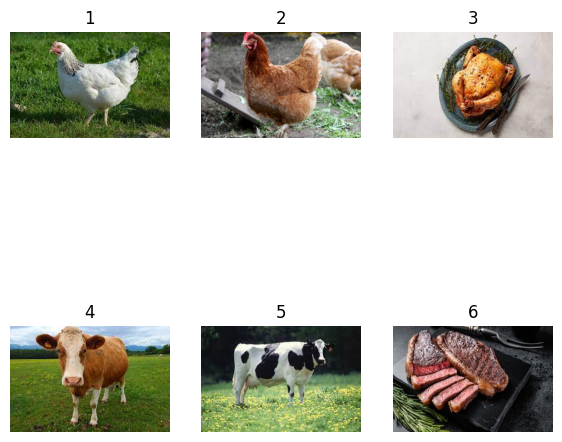

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

numImages = 6
fig = plt.figure(figsize=(7,7))
# initialized imgData to None, will update accordingly after reading in first image
imgData = None

for i in range(1,numImages+1):
    filename = './Animals/animals'+str(i)+'.jpg'
    img = mpimg.imread(filename)
    ax = fig.add_subplot(2,3,i)
    plt.imshow(img)
    plt.axis('off')
    ax.set_title(str(i))
    
    # flatten & reshape image to ensure its 1D array
    flattened_img = img.flatten()
    
    # initializing imgData array w/ correct shape
    if imgData is None:
        imgData = np.zeros((numImages, flattened_img.shape[0]))

    # assigning flattened image to corresponding row in imgData
    imgData[i-1] = flattened_img

plt.show()

The data matrix has been projected to its first 2 principle components, pc1 and pc2.

In [35]:
import pandas as pd
from sklearn.decomposition import PCA
numComponents = 2
pca = PCA(n_components=numComponents)
pca.fit(imgData)
projected = pca.transform(imgData)
projected = pd.DataFrame(
    projected,columns=['pc1','pc2'],index=range(1,numImages+1))
projected['animal'] = ['chicken', 'chicken', 'chicken', 'cow', 'cow', 'cow']
projected

,pc1,pc2,animal
1,-14909.987445,-3726.450579,chicken
2,2867.967444,4429.157644,chicken
3,33982.368740,3799.704747,chicken
4,2334.473480,-17856.198222,cow
5,-11923.081797,21556.420324,cow
6,-12351.740422,-8202.633914,cow


The scatter plot displays the projected values. The images for chicken seem to follow the x-axis while the images for cow are loosely arranged in a vertical pattern. The images for chicken and cow were chosen randomly. Each animal image has a different color scheme, making it difficult for the PCA to group similar images.

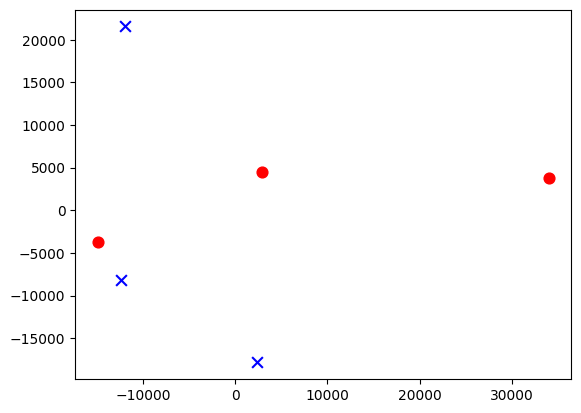

In [36]:
import matplotlib.pyplot as plt

colors = {'cow': 'b', 'chicken': 'r'}
markerTypes = {'cow': 'x', 'chicken': 'o'}

for animalType in markerTypes:
    d = projected[projected['animal'] == animalType]
    plt.scatter(d['pc1'], d['pc2'], c = colors[animalType],
    s = 60, marker = markerTypes[animalType])

plt.show()